In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import pandas as pd
import japanize_matplotlib
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_validate

from utils import load_data, PropertyDataTransformer

In [2]:
X, y = load_data()

pt = PropertyDataTransformer(formula = """
price ~
is_house +
(
    is_new +
    date +
    C(building_type, contr.treatment('NA')) +
    C(building_type, contr.treatment('NA')):age
):house_m2 +
(
    date +
    nearest_station_name +
    nearest_station_minutes +
    road +
    C(floor_ratio, contr.treatment('150.0')) +
    C(building_ratio, contr.treatment('80.0')) +
    C(orientation, contr.treatment('東')) +
    C(land_shape, contr.treatment('正方形'))
):land_m2
- 1
""")
X = pt.fit_transform(X)

In [3]:
model = LassoCV(alphas=[0.1, 1, 10, 100, 1000, 10000], max_iter=10000, tol=0.1, fit_intercept=False)
scores = pd.DataFrame(
    cross_validate(
        model,
        X, y,
        scoring=['r2', 'neg_mean_absolute_percentage_error'],
        return_train_score=True,
        cv=100
    )
)
model.fit(X, y)
scores.apply([np.mean, np.median], axis=0).T

,mean,median
fit_time,0.546870,0.507030
score_time,0.005551,0.004427
test_r2,0.597427,0.612902
train_r2,0.690526,0.690416
test_neg_mean_absolute_percentage_error,-0.282516,-0.247287
train_neg_mean_absolute_percentage_error,-0.274283,-0.274678


[(-1.0, 0.0)]

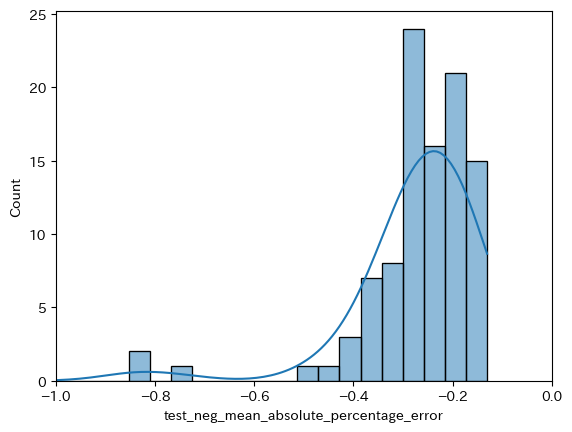

In [4]:
h = sns.histplot(data=scores, x='test_neg_mean_absolute_percentage_error', kde=True)
h.set(xlim=(-1, 0))

In [11]:
s = pd.DataFrame({
    'coef': X.columns,
    'value': model.coef_
})
s.to_csv('coef_.csv', index=False)
s.sort_values('value').style.format("{:}")
s[~s['coef'].str.contains('area|nearest')].sort_values('value').style.format("{:}")
# s[s['coef'].str.contains('nearest')].sort_values('value').style.format("{:}")
s[s['coef'].str.contains('building_type')].sort_values('value').style.format("{:}")


,coef,value
492,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]:age:house_m2",-11288.549280689102
493,"C(building_type, contr.treatment('NA'))[鉄骨造]:age:house_m2",-8616.915757810546
491,"C(building_type, contr.treatment('NA'))[木造]:age:house_m2",-8581.652972331347
3,"C(building_type, contr.treatment('NA'))[NA]:house_m2",0.0
490,"C(building_type, contr.treatment('NA'))[NA]:age:house_m2",0.0
5,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]:house_m2",229092.05051305212
4,"C(building_type, contr.treatment('NA'))[木造]:house_m2",233685.62830779827
6,"C(building_type, contr.treatment('NA'))[鉄骨造]:house_m2",278066.1073723357


In [8]:
233685.62830779827/-8581.652972331347

-27.23084108169358

In [2]:
x = {
    'is_new': 0,
    'is_house': 1,
    'price': 72800000,
    'orientation': '南',
    'house_m2': 96,
    'land_m2': 88,
    'building_type': '軽量鉄骨造',
    'age': 2025-2015,
    'area_name': '王子',
    'nearest_station_name': '王子',
    'nearest_station_minutes': 12,
    'building_ratio': str(60.0),
    'floor_ratio': str(150.0),
    'area': '滝野川',
    'area_plan': '１中住専',
    'land_shape': 'ほぼ長方形',
    'next': '住宅',
    'date': int(2025) - 2020,
    'road': 10
}
yy = x['price']
x = pt.model_spec.get_model_matrix(x)
# i = 4340
# x = X.iloc[i:i + 1, :]
x

NameError: name 'pt' is not defined

In [3]:
import matplotlib.pyplot as plt

data = pd.DataFrame({
    'y_pred': model.predict(X),
    'y_true': y,
    'is_house': X.is_house
})
sns.scatterplot(data, x='y_pred', y='y_true', hue='is_house', alpha=0.5)
sns.lineplot(data, x='y_true', y='y_true')

# model.fit(X, y.values[:, 0])
yp = model.predict(x)[0]
# yy = y.iloc[i].values[0]
plt.scatter(yp, yy, c='r', linewidths=20)

plt.title(f'{yy / yp - 1:.1%} compared to prediction = {yp / 10000:,.0f}万円')
plt.xlim(0, 2e8)
plt.ylim(0, 2e8)

NameError: name 'pd' is not defined

In [10]:
xx = x.T.reset_index()
xx.columns = ['coef', 'value']
xx
xxx = xx.merge(s, on='coef')
xxx
xxx['m'] = xxx['value_x'] * xxx['value_y'] / 10000
h = xxx[xxx['m'] != 0]
h

,coef,value_x,value_y,m
0,is_house,1,-1.074667e+07,-1074.667354
2,date:house_m2,480,3.246073e+04,1558.114868
8,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]...",96,3.708120e+05,3559.794744
22,date:land_m2,440,3.334766e+04,1467.297108
333,area_name[王子]:land_m2,88,4.380132e+05,3854.516048
462,nearest_station_minutes:land_m2,1056,-7.607989e+03,-803.403659
463,road:land_m2,880,3.220629e+03,283.415326
484,"C(orientation, contr.treatment('接面道路無'))[T.南]:...",88,-8.840163e+04,-777.934356
492,"C(land_shape, contr.treatment('正方形'))[T.ほぼ長方形]...",88,-6.348635e+03,-55.867986
502,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]...",960,-9.821467e+03,-942.860837


In [15]:
house = h[h['coef'].str.contains('house')]['m'].sum()
land = h[h['coef'].str.contains('land')]['m'].sum()
print(f"house = {house:,.0f}\nland = {land:,.0f}\nhouse vs total = {house /(house + land):.2%}")

house = 2,374
land = 5,552
house vs total = 29.96%


In [10]:
import joblib

joblib.dump(pt, 'proptrans.pkl')

['proptrans.pkl']

In [11]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [15]:
f = joblib.load('model.pkl')

In [16]:
f.predict(x)

array([76991397.65999748])

In [13]:
pt = joblib.load('proptrans.pkl')

In [14]:
x = {
    'is_new': 0,
    'is_house': 1,
    'price': 72800000,
    'orientation': '南',
    'house_m2': 96,
    'land_m2': 88,
    'building_type': '軽量鉄骨造',
    'age': 2025-2015,
    'nearest_station_name': '王子',
    'nearest_station_minutes': 12,
    'building_ratio': str(60.0),
    'floor_ratio': str(150.0),
    'area': '滝野川',
    'area_plan': '１中住専',
    'land_shape': 'ほぼ長方形',
    'next': '住宅',
    'date': int(2025) - 2020,
    'road': 10
}
yy = x['price']
x = pt.model_spec.get_model_matrix(x)

In [8]:
kita = pd.read_csv('data/kita2.csv')
ita = pd.read_csv('data/ita2.csv')
hachi = pd.read_csv('data/hachi2.csv')
meguro = pd.read_csv('data/meguro2.csv')
arakawa = pd.read_csv('data/ara2.csv')
minato = pd.read_csv('data/minato.csv')
shibuya = pd.read_csv('data/shibu2.csv')
shinjuku = pd.read_csv('data/shin2.csv')
bunkyo = pd.read_csv('data/bun2.csv')
shinagawa = pd.read_csv('data/shina2.csv')
nakano = pd.read_csv('data/naka2.csv')
nerima = pd.read_csv('data/neri2.csv')
df = pd.concat([nerima, kita, ita, hachi, meguro, shibuya, arakawa, minato, shinjuku, bunkyo, shinagawa, nakano]).reset_index()

In [40]:
l = df[['市区町村名', '最寄駅：名称']]\
    .drop_duplicates()\
    .sort_values(by=['市区町村名', '最寄駅：名称'], ascending=False)\
    .groupby('市区町村名')\
    .agg({'市区町村名': lambda x: min(x), '最寄駅：名称': list})\
    .to_dict(orient='records')

In [41]:
d = {}
for ll in l:
    d[ll['市区町村名']] = ll['最寄駅：名称']

In [42]:
d

{'中野区': ['鷺ノ宮',
  '高円寺',
  '阿佐ケ谷',
  '野方',
  '都立家政',
  '西新宿五丁目',
  '落合南長崎',
  '落合',
  '笹塚',
  '沼袋',
  '江古田',
  '東高円寺',
  '東長崎',
  '東中野',
  '方南町',
  '新高円寺',
  '新江古田',
  '新井薬師前',
  '新中野',
  '幡ケ谷',
  '富士見台',
  '井荻',
  '中野新橋',
  '中野富士見町',
  '中野坂上',
  '中野(東京)',
  '中村橋',
  '中井',
  '下井草',
  nan],
 '八王子市': ['高尾山口',
  '高尾(東京)',
  '長沼(東京)',
  '豊田',
  '西八王子',
  '秋川',
  '相原',
  '狭間',
  '片倉',
  '武蔵五日市',
  '松が谷',
  '東秋留',
  '日野(東京)',
  '平山城址公園',
  '山田(東京)',
  '小宮',
  '大塚・帝京大学',
  '多摩境',
  '南大沢',
  '北野(東京)',
  '北八王子',
  '八王子みなみ野',
  '八王子',
  '京王片倉',
  '京王多摩センター',
  '京王堀之内',
  '京王八王子',
  '中央大学・明星大学',
  'めじろ台',
  nan],
 '北区': ['駒込',
  '飛鳥山',
  '赤羽岩淵',
  '赤羽',
  '赤土小学校前',
  '西日暮里',
  '西巣鴨',
  '西ケ原四丁目',
  '西ケ原',
  '荒川遊園地前',
  '荒川車庫前',
  '田端',
  '王子神谷',
  '王子',
  '滝野川一丁目',
  '浮間舟渡',
  '梶原',
  '栄町(東京)',
  '板橋本町',
  '板橋',
  '東十条',
  '本蓮沼',
  '新板橋',
  '新三河島',
  '志茂',
  '志村坂上',
  '尾久',
  '十条(東京)',
  '北赤羽',
  '上中里'],
 '品川区': ['鮫洲',
  '高輪台',
  '馬込',
  '青物横丁',
  '長原(東京)',
  '西小山',
  '西大井',
  '荏原町',
  '荏原中延',
  '

In [39]:
df['前面道路：方位'].unique()

array(['北', '南', '西', '南西', '東', nan, '南東', '北西', '北東', '接面道路無'],
      dtype=object)